In [ ]:
!pip install tensorflow-datasets==1.2.0

In [2]:
from google.colab import files
from google.colab import drive
from os.path import join
ROOT = '/content/drive'
drive.mount(ROOT)

Mounted at /content/drive


In [3]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Dense, LSTM, Bidirectional, TimeDistributed
import tensorflow.keras.backend as K
import pandas as pd
import pickle

In [4]:
# Definimos algunos parámetros e hyper-parámetros de nuestro modelo

BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 32
NUM_LAYERS = 6
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.2
LATENT_SPACE = 32
A = 0.0000001 # Pendiente de función que pondera el peso de la kl_loss a lo largo de los entrenamientos
B = 0.00001 # determina el peso de la kl_loss al comienzo del entrenamiento 

tf.random.set_seed(1234)
pd.options.display.max_colwidth = 100

In [5]:
# Traemos el repositorio de git
PROJ = '/content/repository/'
PROJECT_PATH = join(ROOT, PROJ)

GIT_USERNAME = "Adrok24"
GIT_REPOSITORY = "Proyecto-T-VAE"

!rm -r "{PROJECT_PATH}"
!mkdir '{PROJECT_PATH}'
!git clone https://github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git "{PROJECT_PATH}"

rm: cannot remove '/content/repository/': No such file or directory
Cloning into '/content/repository'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 418 (delta 123), reused 100 (delta 40), pack-reused 198
Receiving objects: 100% (418/418), 52.62 MiB | 22.49 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [6]:
# Instanciamos el init que se encarga de levantar todas nuestras librerías personalizadas
from importlib.machinery import SourceFileLoader
problem_module = SourceFileLoader('tvae_module', join(PROJECT_PATH,'tvae_model/__init__.py')).load_module()

from tvae_module import *

In [7]:
## Cargamos nuestro Dataset
DRIVE_FOLDER = '/content/drive/My Drive/Colab Notebooks/desafio final/'

path_to_corpus = os.path.join(DRIVE_FOLDER, 'train_corpus_v3.csv')
path_to_corpus

'/content/drive/My Drive/Colab Notebooks/desafio final/train_corpus_v3.csv'

In [8]:
data = pd.read_csv(path_to_corpus, index_col=0)

In [9]:
data.sample(5)

,line,len,book,genre,category,Sentimiento
156218,"se sentía muy a gusto en aquella habitación , mucho más de lo que se había sentido en el vestí...",128,El_beso_-_Danielle_Steel,Novelas,Book,POS
113229,@name no quería que hubiera ninguna demora y así se dijo,58,Destinos_errantes_-_Danielle_Steel,Novelas,Book,NEU
279121,"por cierto , gracias por la guirnalda era la primera vez que le agradecía algo",82,argo_camino_a_casa_-_Danielle_Steel,Novelas,Book,POS
75589,que esa señal sean los bosques y los desiertos,48,_frente_al_espejo_-_Denis_Hernandez,poesía,Book,NEU
85688,"te presto mi cuarto , mi almohada , mi cama",49,Susurros_del_Alma_-_Alec_Blackhell,poesía,Book,NEU


In [10]:
## tokenizador de subwords
path_to_tokenizer = os.path.join(DRIVE_FOLDER, 'tokenizer.pkl')
with open(path_to_tokenizer, 'rb') as tk_pkl:
        tokenizer = pickle.load(tk_pkl)

VOCAB_SIZE = tokenizer.vocab_size

### Preprocesamiento

In [11]:
# Dividimos el Dataset en datos de train y de test estratificando por género
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['line', 'len', 'book', 'Sentimiento']], data['genre'], test_size=0.20, random_state=42, stratify=data['genre'])
print('X_train: ',X_train.shape, 'X_test: ',X_test.shape, 'y_train: ',y_train.shape, 'y_test: ',y_test.shape)

X_train:  (253294, 4) X_test:  (63324, 4) y_train:  (253294,) y_test:  (63324,)


In [12]:
# Concatenamos nuevamente el set de entrenamiento
data_train = pd.concat([X_train, y_train],axis=1)

In [13]:
data_tokens = tokenize_and_filter_df(data_train, tokenizer, MAX_LENGTH)

In [14]:
data_tokens.head(3)

,line,secuence,len,genre,sent
0,¡ quieta ! ¡ conviene para tu carrera de artista !,"[64, 7234, 8030, 1522, 6949, 7965, 29, 81, 3434, 2, 5241, 66]",12,Novelas,NEU
1,supongo que podría deshacerme de mis preciosos muebles y modernizarlo un poquito,"[614, 3, 282, 7038, 664, 28, 2, 192, 2858, 20, 5856, 20, 6, 4792, 2944, 14, 13, 1079, 2725, 8044]",20,Novelas,NEU
2,había cuatro hombres inclinados sobre su cuerpo,"[22, 456, 385, 2034, 53, 73, 18, 1267]",8,Novelas,NEU


In [15]:
# Aplicamos un padding con nuestro MAX_LENGTH
data_lines = tf.keras.preprocessing.sequence.pad_sequences(
    data_tokens.secuence.tolist(), maxlen=MAX_LENGTH, padding='post')
  
data_lines[0]

array([  64, 7234, 8030, 1522, 6949, 7965,   29,   81, 3434,    2, 5241,
         66,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [16]:
print('Tamaño vocabulario: {}'.format(VOCAB_SIZE))
print('frases: {}'.format(len(data_lines)))

Tamaño vocabulario: 8189
frases: 249849


In [17]:
# Tomamos la mayor cantidad de frases que sea multiplo de [BATCH_SIZE] para no generar problemas en el entrenamiento
FINAL_LINES = int(len(data_lines) / BATCH_SIZE) * BATCH_SIZE
FINAL_LINES

249792

In [18]:
# Adapto para que de un multiplo del batch size (64)
data_lines = data_lines[0:FINAL_LINES]
len(data_lines)

249792

In [19]:
# saco el token de start de los outputs
dataset = tf.data.Dataset.from_tensor_slices((data_lines,data_lines))
dataset = dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)

### Modelo VAE

In [20]:
# Instanciamos el Encoder y Decoder
encoder = encoder(VOCAB_SIZE, NUM_LAYERS, UNITS, D_MODEL, NUM_HEADS, DROPOUT, LATENT_SPACE, MAX_LENGTH)
decoder = decoder(VOCAB_SIZE, NUM_LAYERS, UNITS, D_MODEL, NUM_HEADS, DROPOUT, LATENT_SPACE, MAX_LENGTH)

# Instanciamos el modelo
model = VAEModel(
      encoder,
      decoder,
      a=A,
      b=B,
      vocab_size=VOCAB_SIZE,
      num_layers=NUM_LAYERS,
      units=UNITS,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
      dropout=DROPOUT,
      latent_space=LATENT_SPACE,
      tokenizer=tokenizer,
      function='linear')

### Entrenamiento

In [25]:
FILE_WEIGTHS = 'weights_kl_speed_up.HDF5'
model.load_weights(join(DRIVE_FOLDER, FILE_WEIGTHS)) #Para fine tunning, levantamos un modelo pre entrenado

In [23]:
# Definimos un Callback que se ejecuta al finalizar cada epoch y se encarga de:
# 1- Generar muestras y metricas para ir evaluando la performance de nuestro modelo durante el entrnamiento
# 2- Guardar el modelo
from tensorflow.keras.callbacks import Callback, LambdaCallback
from random import randint

class EpochEndCallback(Callback): 
    def __init__(self, period=1):
        super(EpochEndCallback, self).__init__()
        self.period = period
    
    def on_epoch_end(self, epoch, logs=None):
        print('Callback running', epoch)
        q_sample = data_lines[randint(0,data_lines.shape[0]) - 1]
        model.reconstruct(q_sample)
        print('gen_norm:')
        [print(sentence) for sentence in generate_from_normal(model, 2, latent_space=LATENT_SPACE)]
        if epoch % 25 == 0:
          model.save_weights(join(DRIVE_FOLDER, FILE_WEIGTHS), save_format='tf')    

# Instanciamos nuestro custom callback
eec = EpochEndCallback()

In [23]:
#Definimos un Callback para actualizar epoch y generar variable de conteo de epochs
def count(epoch):
  K.set_value(beta, epoch)

counter = LambdaCallback(on_epoch_end=lambda epoch, log: count(epoch))

In [26]:
#Entrenamiento y fine-tunning
EPOCHS = 2
model.a = 0.00002
model.b = 0.025

optimizer = tf.keras.optimizers.Adam(0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-9) #for fine-tunning

model.compile(optimizer=optimizer)

history = model.fit(dataset, epochs=EPOCHS, callbacks=[eec])

Epoch 1/2
3903/3903 [==============================] - 419s 103ms/step - loss: 1.3161 - reconstruction_loss: 0.2551 - kl_loss: 53.0469 - kl_weight: 0.0200
Callback running 0
[4, 3058, 82, 2, 157, 6, 1621, 140, 140, 2690, 5, 94, 2135, 6543, 223, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Reconstr:  la echaba mucho de menos y aquellas cosas cosas podrían a ser insoportabte
Original:  la echaba mucho de menos y aquellas dos semanas iban a ser insoportables
gen_norm:
pero toda el acababa de abries flores me me bae y te dejaron el día más en observary
quería volvía a ponerse al marges de ante ella
Epoch 2/2
3903/3903 [==============================] - 400s 103ms/step - loss: 1.3132 - reconstruction_loss: 0.2412 - kl_loss: 53.6003 - kl_weight: 0.0200
Callback running 1
[86, 7352, 72, 5, 53, 238, 1, 19, 728, 6502, 7965, 7, 6786, 8048, 1, 7, 896, 2450, 8030, 1, 7, 8, 3900, 7965, 7012, 3994, 25, 151, 1848, 126, 0, 0]
Reconstr:  fue condenada a dos años  ,  por traficar en drogas  ,  en 

# Evaluación del entrnamiento

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

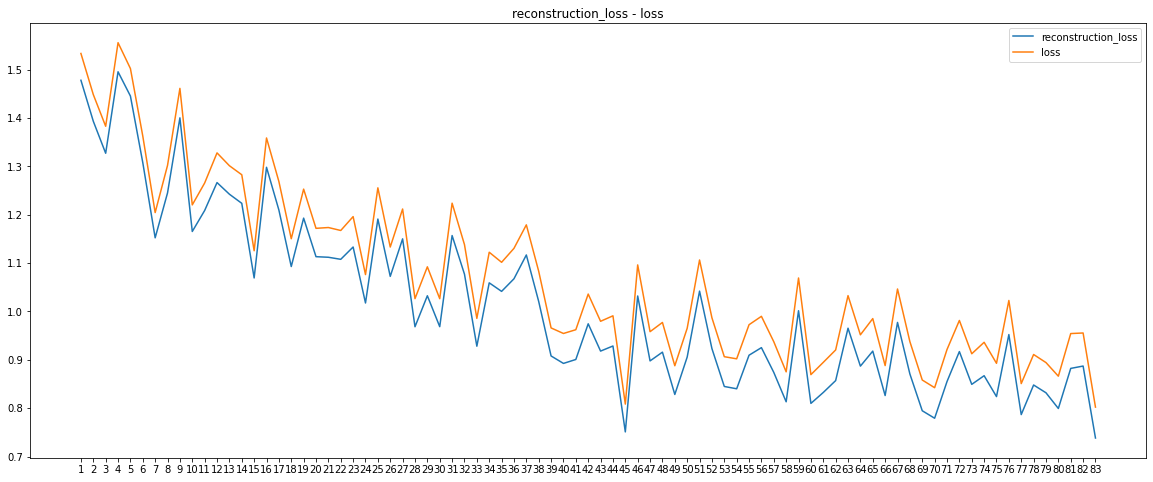

In [38]:
reconstruction_loss = model.history.history['reconstruction_loss']
loss = [np.mean(x) for x in model.history.history['loss']]
# kl_loss = [np.mean(x) for x in model.history.history['kl_loss']] 

epochs = range(1, len(reconstruction_loss) + 1)

plt.figure(figsize=(20,8))
plt.plot(epochs, reconstruction_loss, label='reconstruction_loss')
plt.plot(epochs, loss, label='loss')
# plt.plot(epochs, kl_loss, label='kl_loss')
plt.xticks(ticks=epochs)
# plt.ylim([20000, 40000])
# plt.xlim([30, 100])
plt.title('reconstruction_loss - loss')
plt.legend()

plt

In [ ]:
#Evolucion KL LOSS
kl_loss = [np.mean(x) for x in model.history.history['kl_loss']]

epochs = range(1, len(kl_loss) + 1)

plt.figure(figsize=(20,8))
plt.plot(epochs, kl_loss, label='kl_loss')
plt.xticks(ticks=epochs)
plt.title('rkl_loss')
plt.legend()

plt

In [29]:
# Guardamos los pesos actualizados
FILE_WEIGTHS = 'weights_normal.HDF5'
model.save_weights(join(DRIVE_FOLDER, FILE_WEIGTHS), save_format='tf')